<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Trouver les facteurs explicants les erreurs de reconstruction </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur</u> : Lorenzo HERMEZ  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  28 juin 2022  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle VAE expliquant les erreurs
- construction du modèle
- entrainement
- évaluation de la représentation obtenue


<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

2022-07-19 11:31:43.704739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 11:31:43.704765: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#root git folder 
name_model="vae_error1"
path_second_folder = %pwd 
save_path = os.path.join(path_second_folder,"Results")
log_dir_model=os.path.join(save_path,"logs")
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [3]:
import importlib

sys.path.append(path_second_folder+'/src')

#import models, loss_class, params_class,AE_blocks,metrics
from src.models import *
#importlib.reload(models)
from src.loss_class import *
#importlib.reload(loss_class)
from src.params_class import *
#importlib.reload(params_class)
import src.AE_blocks
#importlib.reload(AE_blocks)
from src.metrics import *
#importlib.reload(metrics)
from src.utils import *

%load_ext autoreload
%autoreload 2


2022-07-19 11:31:46.622270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-19 11:31:46.622302: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-19 11:31:46.622323: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gm0winl472.bureau.si.interne): /proc/driver/nvidia/version does not exist
2022-07-19 11:31:46.622541: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2020. 

In [4]:
# Load dataframe
dataset_csv = os.path.join('data', "dataset_2012_2020.csv")
df_data = pd.read_csv(dataset_csv, sep=";",)
df_data.utc_datetime = pd.to_datetime(df_data.utc_datetime, utc=True)

#Visualize data frame head
df_data.tail(5)

utc_datetime  Consommation  prevision_j  prevision_j-1  \
157819 2020-12-31 21:30:00+00:00       64423.0      63700.0        64400.0   
157820 2020-12-31 22:00:00+00:00       63505.0      63200.0        63800.0   
157821 2020-12-31 22:30:00+00:00       64331.0      65200.0        65800.0   
157822 2020-12-31 23:00:00+00:00       66853.0      67000.0        67500.0   
157823 2020-12-31 23:30:00+00:00       66750.0      67200.0        67600.0   

        prevision_neb  prevision_temp  is_holidays  
157819       3.400764        2.328079          0.0  
157820       3.479000        2.164250          0.0  
157821       3.490986        2.029558          0.0  
157822       3.369000        1.950550          0.0  
157823       3.045322        1.953771          0.0

On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, tout ce qui va être inséré comme entrées du modèle est ici normalisé sur l'ensemble des mesures, puis mis en profils journaliers.

Notre jeu d'entrainement et pour référence est le jeu de données 2012-2018.

In [5]:
ds = pd.DataFrame({"days" : df_data.utc_datetime.dt.date, "minute":df_data.utc_datetime.dt.minute+60*df_data.utc_datetime.dt.hour})

df_conso, df_temp, df_prevision = make_chronics(df=pd.concat([df_data, ds], axis=1),
                                               toshape_columns=["Consommation", "prevision_temp", "prevision_j-1"],
                                               pivot_indexcol="days", pivot_columncol="minute")

df_conso.head()

minute         0        30       60       90       120      150      180   \
days                                                                        
2012-01-01  58315.0  58315.0  56231.0  56075.0  55532.0  54911.0  52496.0   
2012-01-02  55164.0  53643.0  51404.0  50842.0  50399.0  50113.0  48201.0   
2012-01-03  64600.0  63033.0  60533.0  60426.0  60104.0  59861.0  57915.0   
2012-01-04  65081.0  63129.0  60564.0  60194.0  59709.0  59353.0  57569.0   
2012-01-05  67042.0  65123.0  62447.0  62331.0  61889.0  61501.0  59574.0   

minute         210      240      270   ...     1140     1170     1200  \
days                                   ...                              
2012-01-01  50664.0  49161.0  47596.0  ...  57333.0  57786.0  57752.0   
2012-01-02  47182.0  46306.0  46294.0  ...  73263.0  72615.0  71079.0   
2012-01-03  56691.0  55743.0  55656.0  ...  76698.0  75660.0  73535.0   
2012-01-04  56545.0  55655.0  55628.0  ...  78337.0  77173.0  75281.0   
2012-01-05  58245.0  57258.0  56923.0  ...  78351.0  76928.0  74868.0   

minute         1230     1260     1290     1320     1350     1380     1410  
days                                                                       
2012-01-01  56946.0  56054.0  54975.0  53890.0  54348.0  56577.0  55634.0  
2012-01-02  69050.0  67435.0  65332.0  63756.0  64030.0  65929.0  64902.0  
2012-01-03  71275.0  69189.0  66829.0  64861.0  64898.0  66939.0  65479.0  
2012-01-04  72985.0  70927.0  68726.0  66808.0  66878.0  68550.0  67376.0  
2012-01-05  72432.0  70197.0  68036.0  66269.0  66070.0  68169.0  66910.0  

[5 rows x 48 columns]

In [6]:
df_conso, conso_scaler = apply_scaler(df_data, column="Consommation", df_chronic=df_conso,
                                      reference_window=df_data.utc_datetime.dt.year <=2018)
df_conso.head()

minute          0         30        60        90        120       150   \
days                                                                     
2012-01-01  0.306926  0.306926  0.135886  0.123082  0.078516  0.027549   
2012-01-02  0.048313 -0.076520 -0.260282 -0.306408 -0.342766 -0.366239   
2012-01-03  0.822757  0.694148  0.488965  0.480183  0.453756  0.433812   
2012-01-04  0.862234  0.702027  0.491509  0.461142  0.421337  0.392118   
2012-01-05  1.023180  0.865682  0.646053  0.636533  0.600256  0.568412   

minute          180       210       240       270   ...      1140      1170  \
days                                                ...                       
2012-01-01 -0.170658 -0.321017 -0.444373 -0.572818  ...  0.226330  0.263510   
2012-01-02 -0.523163 -0.606796 -0.678692 -0.679677  ...  1.533758  1.480575   
2012-01-03  0.274097  0.173639  0.095834  0.088693  ...  1.815680  1.730488   
2012-01-04  0.245700  0.161657  0.088611  0.086395  ...  1.950198  1.854665   
2012-01-05  0.410257  0.301181  0.220175  0.192680  ...  1.951348  1.834557   

minute          1200      1230      1260      1290      1320      1350  \
days                                                                     
2012-01-01  0.260719  0.194568  0.121359  0.032801 -0.056248 -0.018659   
2012-01-02  1.354510  1.187984  1.055435  0.882835  0.753487  0.775975   
2012-01-03  1.556082  1.370597  1.199392  1.005699  0.844178  0.847215   
2012-01-04  1.699382  1.510942  1.342035  1.161392  1.003975  1.009720   
2012-01-05  1.665486  1.465555  1.282122  1.104761  0.959738  0.943405   

minute          1380      1410  
days                            
2012-01-01  0.164283  0.086888  
2012-01-02  0.931833  0.847543  
2012-01-03  1.014727  0.894900  
2012-01-04  1.146947  1.050593  
2012-01-05  1.115677  1.012347  

[5 rows x 48 columns]

In [7]:
np.random.rand(10000).std()

0.29084438190091894

In [8]:
df_slope = df_conso
df_test_slope = np.zeros_like(df_slope)
print(df_test_slope)
for i in range(df_test_slope.shape[0]):
    df_test_slope[i,0] = (df_slope.values[i,1]-df_slope.values[i,0])/2
    df_test_slope[i,-1] = (df_slope.values[i,-1]-df_slope.values[i,-2])/2
    for j in range(1,47):
        df_test_slope[i,j] = (df_slope.values[i,j+1]- df_slope.values[i,j-1])/2


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


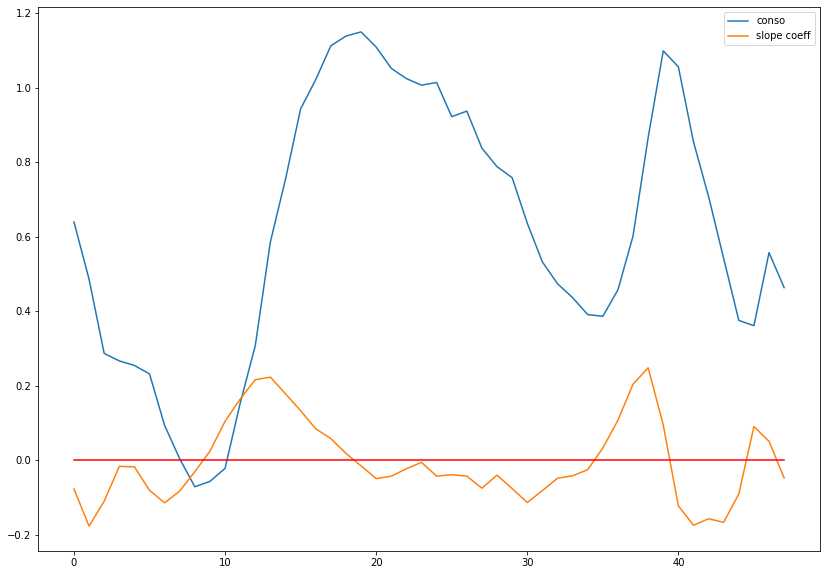

In [9]:
plt.figure(figsize=(14,10))
plt.plot(df_conso.values[80,:],label='conso')
plt.plot(df_test_slope[80,:],label='slope coeff')
plt.plot([0]*48, color='red')
plt.legend()

In [10]:
np.argmax(df_test_slope)

2437

In [11]:
(2437//48)

50

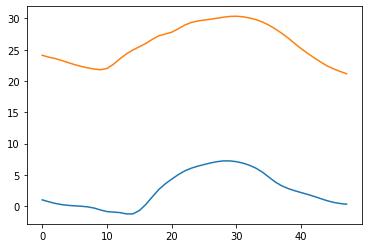

In [12]:
plt.plot(df_temp.values[50,:])
plt.plot(df_temp.values[61441//48,:])

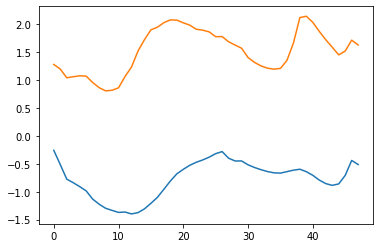

In [13]:
plt.plot(df_conso.values[61441//48,:])
plt.plot(df_conso.values[50,:])

'df_conso' est constitué des profils journaliers de consommation d'lélectricité que l'on va mettre en entrée de notre VAE

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [14]:
#importation des données calendaires
df_calendar = make_df_calendar(pd.DataFrame({"ds" : pd.to_datetime(np.asarray(df_conso.index))}))

df_holidays = pd.concat([df_data[["is_holidays"]],pd.DataFrame({"ds" : pd.to_datetime(ds.days.values)})], axis=1).drop_duplicates(
                                               subset="ds").reset_index(drop= True)

df_calendar = df_calendar.merge(df_holidays, on="ds", how="left").rename(columns={"is_holidays":"is_holiday_day"})

df_calendar.head(5)

ds  month  weekday  is_weekend  year  is_holiday_day
0 2012-01-01      1        6           1  2012             1.0
1 2012-01-02      1        0           0  2012             0.0
2 2012-01-03      1        1           0  2012             0.0
3 2012-01-04      1        2           0  2012             0.0
4 2012-01-05      1        3           0  2012             0.0

In [15]:
#explicit the potential bridge days taken as extended holidays
day_hol = df_calendar[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

df_calendar['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [59]:
df_temp

minute          0         30        60        90        120       150   \
days                                                                     
2012-01-01 -0.237659 -0.263654 -0.264435 -0.255079 -0.250663 -0.261117   
2012-01-02 -0.421302 -0.433458 -0.444241 -0.447363 -0.451692 -0.466808   
2012-01-03 -1.046487 -1.035061 -1.026803 -1.037969 -1.053905 -1.056697   
2012-01-04 -0.682185 -0.689660 -0.698279 -0.708238 -0.720073 -0.734727   
2012-01-05 -0.704680 -0.709543 -0.710615 -0.694748 -0.684025 -0.698425   
...              ...       ...       ...       ...       ...       ...   
2020-12-27 -1.468071 -1.455712 -1.438645 -1.430135 -1.426499 -1.421884   
2020-12-28 -1.168854 -1.174686 -1.184888 -1.189451 -1.188256 -1.185166   
2020-12-29 -1.236770 -1.252088 -1.275239 -1.288612 -1.291939 -1.289360   
2020-12-30 -1.378556 -1.388333 -1.397717 -1.403609 -1.409314 -1.418062   
2020-12-31 -1.342848 -1.337888 -1.331367 -1.326456 -1.324133 -1.324076   

minute          180       210       240       270   ...      1140      1170  \
days                                                ...                       
2012-01-01 -0.275790 -0.282598 -0.284321 -0.286168  ... -0.257951 -0.281316   
2012-01-02 -0.490011 -0.515433 -0.536836 -0.550190  ... -0.971463 -0.975581   
2012-01-03 -1.046280 -1.028972 -1.018751 -1.024257  ... -0.467375 -0.505498   
2012-01-04 -0.754433 -0.780252 -0.807282 -0.831190  ... -0.730870 -0.742222   
2012-01-05 -0.714280 -0.707235 -0.693815 -0.692562  ... -0.463250 -0.488644   
...              ...       ...       ...       ...  ...       ...       ...   
2020-12-27 -1.418708 -1.419705 -1.420604 -1.417033  ... -1.087582 -1.092994   
2020-12-28 -1.190087 -1.209667 -1.231498 -1.241615  ... -1.158354 -1.179874   
2020-12-29 -1.285299 -1.283525 -1.284911 -1.289363  ... -1.242379 -1.254152   
2020-12-30 -1.426389 -1.431943 -1.443522 -1.467629  ... -1.234376 -1.242118   
2020-12-31 -1.322962 -1.318758 -1.317595 -1.323421  ... -1.394854 -1.432540   

minute          1200      1230      1260      1290      1320      1350  \
days                                                                     
2012-01-01 -0.302896 -0.331347 -0.357315 -0.371253 -0.380854 -0.394715   
2012-01-02 -0.982111 -1.002639 -1.020793 -1.020437 -1.014343 -1.018149   
2012-01-03 -0.537682 -0.552961 -0.564520 -0.586857 -0.615579 -0.642470   
2012-01-04 -0.747197 -0.745922 -0.741890 -0.738556 -0.735853 -0.732362   
2012-01-05 -0.516323 -0.547492 -0.579400 -0.609635 -0.641127 -0.676107   
...              ...       ...       ...       ...       ...       ...   
2020-12-27 -1.098792 -1.101406 -1.106450 -1.119986 -1.140672 -1.163665   
2020-12-28 -1.196317 -1.201481 -1.202856 -1.209553 -1.223467 -1.241955   
2020-12-29 -1.262426 -1.275630 -1.292108 -1.308689 -1.326256 -1.345420   
2020-12-30 -1.251963 -1.267331 -1.284735 -1.300112 -1.314000 -1.327307   
2020-12-31 -1.466607 -1.492652 -1.515311 -1.539681 -1.563671 -1.583395   

minute          1380      1410  
days                            
2012-01-01 -0.407830 -0.414679  
2012-01-02 -1.030045 -1.042990  
2012-01-03 -0.662937 -0.674832  
2012-01-04 -0.724787 -0.712155  
2012-01-05 -0.708689 -0.733329  
...              ...       ...  
2020-12-27 -1.177508 -1.174533  
2020-12-28 -1.251458 -1.242988  
2020-12-29 -1.361657 -1.371214  
2020-12-30 -1.337825 -1.343102  
2020-12-31 -1.594965 -1.594493  

[3288 rows x 48 columns]

In [60]:
df_slope

minute          0         30        60        90        120       150   \
days                                                                     
2012-01-01  0.306926  0.306926  0.135886  0.123082  0.078516  0.027549   
2012-01-02  0.048313 -0.076520 -0.260282 -0.306408 -0.342766 -0.366239   
2012-01-03  0.822757  0.694148  0.488965  0.480183  0.453756  0.433812   
2012-01-04  0.862234  0.702027  0.491509  0.461142  0.421337  0.392118   
2012-01-05  1.023180  0.865682  0.646053  0.636533  0.600256  0.568412   
...              ...       ...       ...       ...       ...       ...   
2020-12-27  0.846312  0.730671  0.551341  0.554049  0.517198  0.482974   
2020-12-28  0.693410  0.570710  0.392365  0.378166  0.339427  0.296011   
2020-12-29  0.852550  0.731820  0.562749  0.551669  0.514244  0.470581   
2020-12-30  0.908196  0.776222  0.594019  0.595578  0.555773  0.519004   
2020-12-31  0.982882  0.846230  0.651634  0.633414  0.593444  0.551094   

minute          180       210       240       270   ...      1140      1170  \
days                                                ...                       
2012-01-01 -0.170658 -0.321017 -0.444373 -0.572818  ...  0.226330  0.263510   
2012-01-02 -0.523163 -0.606796 -0.678692 -0.679677  ...  1.533758  1.480575   
2012-01-03  0.274097  0.173639  0.095834  0.088693  ...  1.815680  1.730488   
2012-01-04  0.245700  0.161657  0.088611  0.086395  ...  1.950198  1.854665   
2012-01-05  0.410257  0.301181  0.220175  0.192680  ...  1.951348  1.834557   
...              ...       ...       ...       ...  ...       ...       ...   
2020-12-27  0.346157  0.246192  0.154516  0.125380  ...  1.037051  1.051742   
2020-12-28  0.153367  0.078352  0.005471 -0.009630  ...  1.487223  1.445119   
2020-12-29  0.327363  0.250788  0.164857  0.146309  ...  1.492804  1.456856   
2020-12-30  0.380136  0.303643  0.232158  0.216153  ...  1.511927  1.484761   
2020-12-31  0.406399  0.321207  0.237328  0.202939  ...  1.298290  1.259305   

minute          1200      1230      1260      1290      1320      1350  \
days                                                                     
2012-01-01  0.260719  0.194568  0.121359  0.032801 -0.056248 -0.018659   
2012-01-02  1.354510  1.187984  1.055435  0.882835  0.753487  0.775975   
2012-01-03  1.556082  1.370597  1.199392  1.005699  0.844178  0.847215   
2012-01-04  1.699382  1.510942  1.342035  1.161392  1.003975  1.009720   
2012-01-05  1.665486  1.465555  1.282122  1.104761  0.959738  0.943405   
...              ...       ...       ...       ...       ...       ...   
2020-12-27  1.007750  0.893176  0.784593  0.679868  0.577604  0.607807   
2020-12-28  1.326195  1.151051  0.998312  0.868390  0.753241  0.779833   
2020-12-29  1.351227  1.166644  1.024247  0.906554  0.798628  0.826779   
2020-12-30  1.381923  1.224506  1.079647  0.965154  0.846394  0.883491   
2020-12-31  1.177971  1.045340  0.905487  0.808230  0.732887  0.800679   

minute          1380      1410  
days                            
2012-01-01  0.164283  0.086888  
2012-01-02  0.931833  0.847543  
2012-01-03  1.014727  0.894900  
2012-01-04  1.146947  1.050593  
2012-01-05  1.115677  1.012347  
...              ...       ...  
2020-12-27  0.766619  0.711794  
2020-12-28  0.942010  0.868472  
2020-12-29  0.992485  0.915008  
2020-12-30  1.050593  0.993798  
2020-12-31  1.007668  0.999215  

[3288 rows x 48 columns]

In [16]:
calendar_factors = ["weekday", "is_weekend", "month", "is_holiday_day"]
factors = df_calendar[calendar_factors].copy()
factorDesc = {ff : 'category' for ff in calendar_factors}

temperatureMean= df_temp.mean(axis=1).values.reshape(-1,1)
slopeMean= df_test_slope.mean(axis=1).reshape(-1,1)
factorMatrix = np.c_[factors.values,temperatureMean, slopeMean]
factorDesc['temperature']='regressor'
factorDesc['slope']='regressor'

# Tools to evaluate the representations

In [17]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded, factorMatrix, temperatureMean):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [18]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=df_conso.shape[0]
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [19]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(scaler_conso.inverse_transform(x), label = 'truth')
    plt.plot(scaler_conso.inverse_transform(x_hat), '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE ou CVAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)
- les dimensions de notre embedding des conditions dans le cas dans CVAE

In [20]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,18,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[12,18,24,48,48]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = df_conso.shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [21]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

On va mettre en forme ici les facteurs sur lesquels on va rendre la représentation latente agnostique. Attention à normaliser les variables quantitatives et à one-hot encoder les variables catégorielles. 

In [22]:
#on va conditionner sur les profils de température et le mois
calendar_cond = []
condtovae_dims = []
condarray=[]

df_temp, temp_scaler = apply_scaler(df_data, column="prevision_temp", df_chronic=df_temp,
                                      reference_window=None)

condarray.append(df_temp.values)
condtovae_dims.append(condarray[-1].shape[1])

for cc in calendar_cond:
    condarray.append(pd.get_dummies(df_calendar[cc], prefix=cc).values)
    condtovae_dims.append(condarray[-1].shape[1])



In [23]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [24]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
with_embedding  :=  False
with_Time2Vec  :=  False
emb_dims  :=  []
kernel_initializer  :=  glorot_uniform
bias_initializer  :=  glorot_uniform
reparametrize  :=  GaussianSampling
intel_function  :=  scalar_binary
input_dims  :=  48
output_dims  :=  48
t2v_dims  :=  12
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [12, 10, 8, 6]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [6, 12, 24, 48]
latent_encoder_dims  :=  [4, 3, 3, 4]
latent_mask  :=  0
decoder_type  :=  InceptionBlock_model
embedding_type  :=  EmbeddingBlock_model
cond_dims  :=  []
cond_insert  :=  {'encoder': [], 'decoder': []}
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [25]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = []
vae_params.model_params.cond_dims = []
vae_params.model_params.with_embedding = False
vae_params.model_params.with_Time2Vec = False
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 1
vae_params.model_params.latent_dims = z_dim 

In [26]:
#example of custom loss definition
def loss_1(y_true, y_pred, latent_mu ,eps=2):
    return tf.math.reduce_sum(K.abs(K.sqrt(K.sum(K.square(latent_mu),axis=-1)) - eps))

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{"latent_mu":"kwargs['latent_components'][0]"} }}

loss_weights = {"recon_loss" : 1,
                "kl_loss":0.3,
                "info_loss":75}

vae_loss = VAELoss(loss_weights = loss_weights, custom_loss=None) #change None to custom_loss if will to use one
vae_loss.options["log_prior_sigma"] = [-2,-1,0,1.]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = lr


In [27]:
new_cae=CVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_error1',
 'folder': '/home/hermezlor/Documents/cvae-env/VAE/Results/logs/vae_error1',
 'model_params': <src.params_class.VAEModelParams at 0x7f7a243e24c0>,
 'training_params': <src.params_class.VAETrainingParams at 0x7f7a243e2280>}

In [28]:
new_cae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          6662        ['x_inputs[0][0]']               
                                 (None, 4)]                                                       
                                                                                                  
 reparametrizing_layer (Lambda)  (None, 4)           0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                               

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', min_delta = 0, factor=0.3, patience=200, verbose=0, mode='auto'
)

## START TRAINING ##
Epoch 1/2000
144/144 [==============================] - 2s 5ms/step - loss: 34.3752 - val_loss: 28.8101
Epoch 2/2000
144/144 [==============================] - 0s 2ms/step - loss: 19.7293 - val_loss: 14.0235
Epoch 3/2000
144/144 [==============================] - 0s 2ms/step - loss: 12.2587 - val_loss: 9.3325
Epoch 4/2000
144/144 [==============================] - 0s 2ms/step - loss: 8.5866 - val_loss: 6.9126
Epoch 5/2000
144/144 [==============================] - 0s 2ms/step - loss: 6.4642 - val_loss: 5.4471
Epoch 6/2000
144/144 [==============================] - 0s 2ms/step - loss: 5.2731 - val_loss: 4.7079
Epoch 7/2000
144/144 [==============================] - 0s 2ms/step - loss: 4.6244 - val_loss: 4.2137
Epoch 8/2000
144/144 [==============================] - 0s 2ms/step - loss: 4.1683 - val_loss: 3.7585
Epoch 9/2000
144/144 [==============================] - 0s 2ms/step - loss: 3.8443 - val_loss: 3.4571
Epoch 10/2000
144/144 [==============================] -

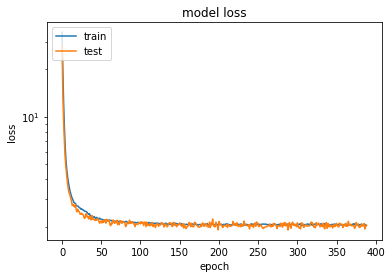

## MODEL SAVED ##


In [30]:
train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019

input_cvae = [df_conso.values[train_set,:]]
output_cvae = df_conso.values[train_set,:]

new_cae.train(input_cvae, output_cvae, epochs= 2000, verbose=1,
              batch_size=batch_size, callbacks=[earl_stop])

## Evaluer l'importance et la qualité des embeggings appris

Nous allons voir:
- l'importance portée par des variables dans la représentation latente
- l'importance portée par des variables dans l'embedding conditionnel

Nous nous appuyons pour cela sur des score d'information, de démêlement, de compacité et de modularité

Nous devrions constater que des variables importante dans l'embedding conditionnel ne le sont plus dans la représentation latente: elles ont été factorisées

In [31]:
x_encoded = new_cae.encoder.predict(input_cvae)[0]

In [32]:
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire

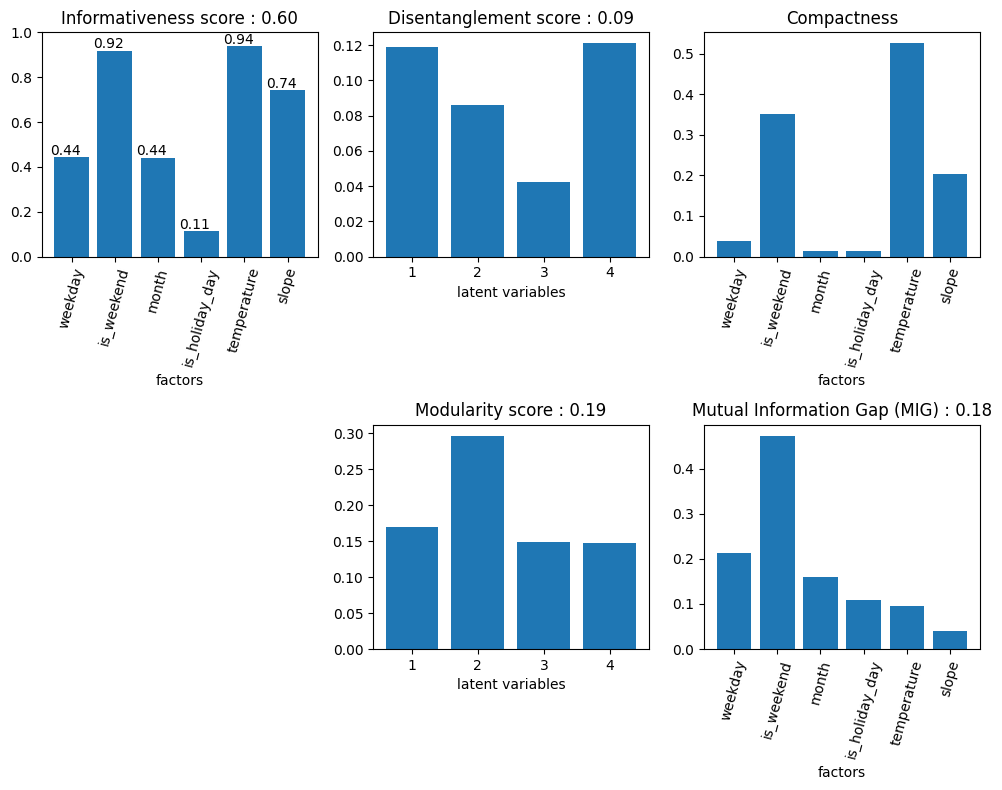

In [33]:
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [34]:
test_input_cvae = [df_conso.values[test_set,:]] 
x_hat = new_cae.model.predict(test_input_cvae)

print(f"reconstruction error to scale : {np.mean(np.abs(conso_scaler.inverse_transform(x_hat).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019]))}")

reconstruction error to scale : 1303.685222468964


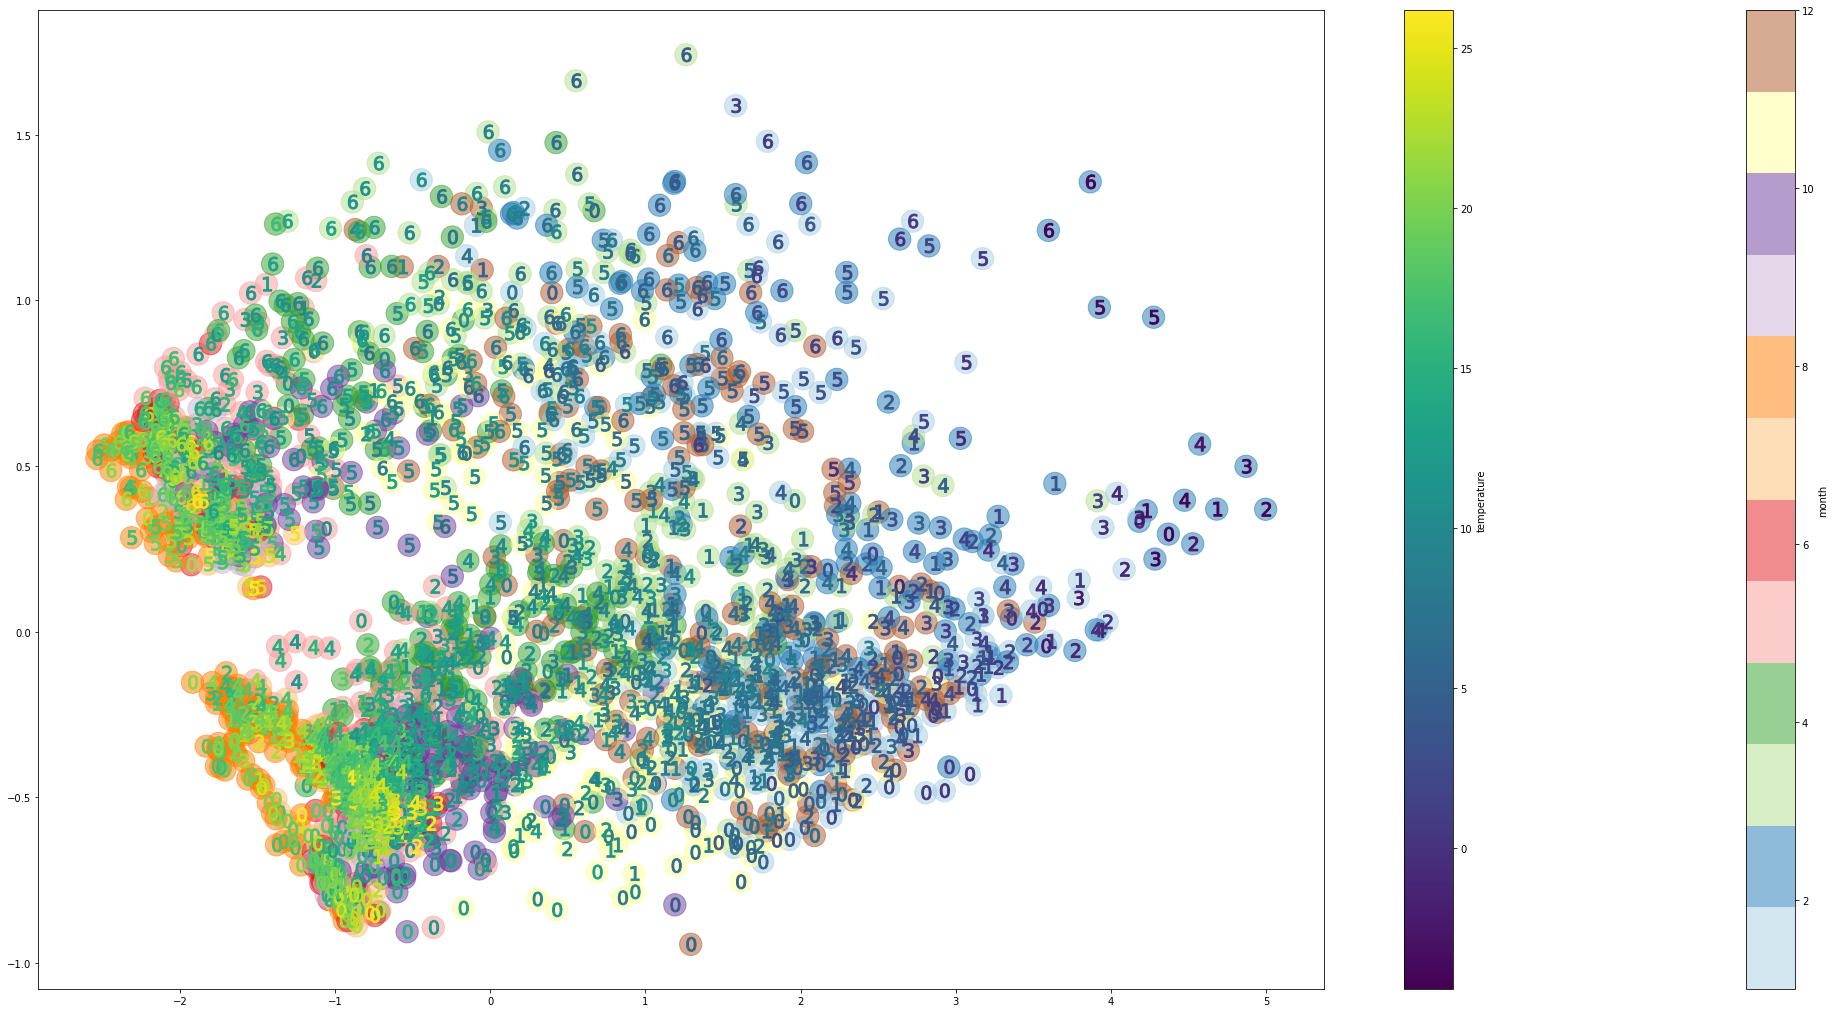

In [35]:
prez_2D(x_encoded, factorMatrix[train_set,:], temperatureMean[train_set])

## Which factors are responsible of this error rate and how to counter them ? 

In [36]:
def create_df_errors(model, inputs):
    x_hat = new_cae.model.predict(inputs)
    df = pd.DataFrame(data=conso_scaler.inverse_transform(x_hat) - df_data.Consommation.values[df_data.utc_datetime.dt.year <= 2018].reshape(x_hat.shape))

    return df

In [37]:
df_errors = create_df_errors(new_cae, input_cvae)

In [38]:
df_errors

0            1            2            3            4   \
0    -1058.734375 -3020.167969 -3682.039062 -4010.046875 -4222.078125   
1     4850.894531  4359.769531  3858.812500  4047.191406  3873.000000   
2    -2355.589844 -2761.574219 -2964.023438 -3062.398438 -3209.742188   
3      857.453125   982.437500   895.527344  1122.777344  1085.242188   
4     -718.250000  -673.574219  -665.605469  -721.804688  -806.781250   
...           ...          ...          ...          ...          ...   
2552  2512.687500  2267.007812  2299.296875  2651.226562  2637.265625   
2553  -142.960938    57.460938    72.882812   522.148438   651.269531   
2554 -1269.820312 -1465.109375 -1359.453125  -846.386719  -890.718750   
2555 -2786.308594 -2988.523438 -2881.136719 -2714.140625 -2577.261719   
2556   139.187500   -63.867188  -120.773438    93.453125   104.734375   

               5            6            7            8            9   ...  \
0    -4287.785156 -3814.960938 -3223.507812 -2850.453125 -1868.285156  ...   
1     3666.058594  3754.242188  3703.707031  3696.894531  3582.320312  ...   
2    -3253.730469 -2991.535156 -2677.605469 -2433.742188 -2126.429688  ...   
3     1073.718750  1037.328125   989.867188   948.515625   909.117188  ...   
4     -790.929688  -697.789062  -433.511719  -343.867188   -15.714844  ...   
...           ...          ...          ...          ...          ...  ...   
2552  2361.558594  2160.941406  1902.460938  1615.652344  1379.531250  ...   
2553   832.113281   695.351562   590.417969   585.777344   592.511719  ...   
2554  -717.097656  -729.042969  -771.398438  -875.832031  -781.410156  ...   
2555 -2421.605469 -2328.574219 -2222.824219 -2129.445312 -2042.382812  ...   
2556   269.976562   228.925781   167.953125    54.292969    10.917969  ...   

               38           39           40           41           42  \
0    -3079.867188 -2827.445312 -2915.707031 -2916.179688 -2540.589844   
1    -3876.132812 -3981.304688 -4009.390625 -4082.339844 -4382.699219   
2    -1128.429688 -1020.007812  -902.375000 -1198.234375 -1491.171875   
3    -4109.187500 -3259.117188 -2885.968750 -2706.539062 -2589.187500   
4      739.976562  1169.804688  1177.492188  1046.289062   836.531250   
...           ...          ...          ...          ...          ...   
2552   619.226562  1281.851562  1566.257812  1414.554688  1317.453125   
2553   276.117188  1030.898438  1234.851562  1163.882812   963.507812   
2554   281.437500   583.671875   716.398438   545.453125   309.664062   
2555   101.507812  -174.609375  -445.507812  -578.785156  -901.992188   
2556  2450.718750  3275.406250  3777.140625  3730.687500  3632.046875   

               43           44           45           46           47  
0    -2007.207031 -1416.988281 -1075.464844  -469.410156  -105.738281  
1    -3858.554688 -3411.367188 -3187.656250 -2574.128906 -2561.765625  
2    -1163.093750  -805.476562  -647.480469  -340.023438     9.843750  
3    -2183.140625 -1728.054688 -1472.335938  -619.406250  -360.140625  
4      887.554688  1106.500000  1629.085938  1969.132812  2132.570312  
...           ...          ...          ...          ...          ...  
2552   942.164062   805.546875   785.492188   880.578125  1155.507812  
2553   258.570312   147.695312    32.015625    79.382812    50.382812  
2554   171.433594  -157.046875  -139.601562  -209.335938   -86.515625  
2555  -892.464844  -922.953125 -1007.894531  -845.023438  -947.160156  
2556  3088.796875  2626.628906  2116.015625  1728.156250  1076.082031  

[2557 rows x 48 columns]

In [39]:
df_errors.index = df_conso.index[:df_errors.shape[0]]
df_errors.columns = df_conso.columns

In [40]:
df_errors

minute             0            30           60           90           120   \
days                                                                          
2012-01-01 -1058.734375 -3020.167969 -3682.039062 -4010.046875 -4222.078125   
2012-01-02  4850.894531  4359.769531  3858.812500  4047.191406  3873.000000   
2012-01-03 -2355.589844 -2761.574219 -2964.023438 -3062.398438 -3209.742188   
2012-01-04   857.453125   982.437500   895.527344  1122.777344  1085.242188   
2012-01-05  -718.250000  -673.574219  -665.605469  -721.804688  -806.781250   
...                 ...          ...          ...          ...          ...   
2018-12-27  2512.687500  2267.007812  2299.296875  2651.226562  2637.265625   
2018-12-28  -142.960938    57.460938    72.882812   522.148438   651.269531   
2018-12-29 -1269.820312 -1465.109375 -1359.453125  -846.386719  -890.718750   
2018-12-30 -2786.308594 -2988.523438 -2881.136719 -2714.140625 -2577.261719   
2018-12-31   139.187500   -63.867188  -120.773438    93.453125   104.734375   

minute             150          180          210          240          270   \
days                                                                          
2012-01-01 -4287.785156 -3814.960938 -3223.507812 -2850.453125 -1868.285156   
2012-01-02  3666.058594  3754.242188  3703.707031  3696.894531  3582.320312   
2012-01-03 -3253.730469 -2991.535156 -2677.605469 -2433.742188 -2126.429688   
2012-01-04  1073.718750  1037.328125   989.867188   948.515625   909.117188   
2012-01-05  -790.929688  -697.789062  -433.511719  -343.867188   -15.714844   
...                 ...          ...          ...          ...          ...   
2018-12-27  2361.558594  2160.941406  1902.460938  1615.652344  1379.531250   
2018-12-28   832.113281   695.351562   590.417969   585.777344   592.511719   
2018-12-29  -717.097656  -729.042969  -771.398438  -875.832031  -781.410156   
2018-12-30 -2421.605469 -2328.574219 -2222.824219 -2129.445312 -2042.382812   
2018-12-31   269.976562   228.925781   167.953125    54.292969    10.917969   

minute      ...         1140         1170         1200         1230  \
days        ...                                                       
2012-01-01  ... -3079.867188 -2827.445312 -2915.707031 -2916.179688   
2012-01-02  ... -3876.132812 -3981.304688 -4009.390625 -4082.339844   
2012-01-03  ... -1128.429688 -1020.007812  -902.375000 -1198.234375   
2012-01-04  ... -4109.187500 -3259.117188 -2885.968750 -2706.539062   
2012-01-05  ...   739.976562  1169.804688  1177.492188  1046.289062   
...         ...          ...          ...          ...          ...   
2018-12-27  ...   619.226562  1281.851562  1566.257812  1414.554688   
2018-12-28  ...   276.117188  1030.898438  1234.851562  1163.882812   
2018-12-29  ...   281.437500   583.671875   716.398438   545.453125   
2018-12-30  ...   101.507812  -174.609375  -445.507812  -578.785156   
2018-12-31  ...  2450.718750  3275.406250  3777.140625  3730.687500   

minute             1260         1290         1320         1350         1380  \
days                                                                          
2012-01-01 -2540.589844 -2007.207031 -1416.988281 -1075.464844  -469.410156   
2012-01-02 -4382.699219 -3858.554688 -3411.367188 -3187.656250 -2574.128906   
2012-01-03 -1491.171875 -1163.093750  -805.476562  -647.480469  -340.023438   
2012-01-04 -2589.187500 -2183.140625 -1728.054688 -1472.335938  -619.406250   
2012-01-05   836.531250   887.554688  1106.500000  1629.085938  1969.132812   
...                 ...          ...          ...          ...          ...   
2018-12-27  1317.453125   942.164062   805.546875   785.492188   880.578125   
2018-12-28   963.507812   258.570312   147.695312    32.015625    79.382812   
2018-12-29   309.664062   171.433594  -157.046875  -139.601562  -209.335938   
2018-12-30  -901.992188  -892.464844  -922.953125 -1007.894531  -845.023438   
2018-12-31  3632.046875  3088.796875  2626.628906  2116.015625  1728.156

In [41]:
scaler = StandardScaler().fit(df_errors.values.ravel().reshape(-1,1))

df_errors_final = df_errors.apply(lambda x: scaler.transform(x.reshape(-1,1)).ravel(), raw=True, axis=1)

In [42]:
df_errors_final

minute          0         30        60        90        120       150   \
days                                                                     
2012-01-01 -0.564371 -1.766896 -2.172679 -2.373776 -2.503769 -2.544053   
2012-01-02  3.058734  2.757632  2.450503  2.565995  2.459201  2.332328   
2012-01-03 -1.359453 -1.608356 -1.732475 -1.792787 -1.883121 -1.910090   
2012-01-04  0.610415  0.687041  0.633758  0.773081  0.750069  0.743004   
2012-01-05 -0.355625 -0.328235 -0.323349 -0.357804 -0.409902 -0.400184   
...              ...       ...       ...       ...       ...       ...   
2018-12-27  1.625214  1.474592  1.494387  1.710150  1.701591  1.532559   
2018-12-28 -0.002924  0.119952  0.129407  0.404845  0.484007  0.594879   
2018-12-29 -0.693784 -0.813513 -0.748737 -0.434184 -0.461363 -0.354919   
2018-12-30 -1.623521 -1.747495 -1.681658 -1.579275 -1.495357 -1.399927   
2018-12-31  0.170057  0.045567  0.010679  0.142018  0.148934  0.250242   

minute          180       210       240       270   ...      1140      1170  \
days                                                ...                       
2012-01-01 -2.254172 -1.891561 -1.662847 -1.060694  ... -1.803497 -1.648741   
2012-01-02  2.386393  2.355410  2.351234  2.280990  ... -2.291675 -2.356155   
2012-01-03 -1.749342 -1.556876 -1.407367 -1.218959  ... -0.607100 -0.540628   
2012-01-04  0.720693  0.691596  0.666244  0.642089  ... -2.434558 -1.913392   
2012-01-05 -0.343081 -0.181056 -0.126097  0.075089  ...  0.538392  0.801913   
...              ...       ...       ...       ...  ...       ...       ...   
2018-12-27  1.409564  1.251093  1.075255  0.930493  ...  0.464362  0.870607   
2018-12-28  0.511033  0.446700  0.443854  0.447983  ...  0.254007  0.716752   
2018-12-29 -0.362242 -0.388210 -0.452236 -0.394348  ...  0.257268  0.442564   
2018-12-30 -1.342891 -1.278057 -1.220808 -1.167431  ...  0.146956 -0.022327   
2018-12-31  0.225074  0.187693  0.118009  0.091417  ...  1.587222  2.092825   

minute          1200      1230      1260      1290      1320      1350  \
days                                                                     
2012-01-01 -1.702853 -1.703143 -1.472874 -1.145865 -0.784011 -0.574628   
2012-01-02 -2.373374 -2.418098 -2.602244 -2.280898 -2.006735 -1.869581   
2012-01-03 -0.468509 -0.649896 -0.829492 -0.628352 -0.409102 -0.312237   
2012-01-04 -1.684621 -1.574615 -1.502669 -1.253727 -0.974721 -0.817944   
2012-01-05  0.806626  0.726187  0.597588  0.628870  0.763102  1.083491   
...              ...       ...       ...       ...       ...       ...   
2018-12-27  1.044972  0.951965  0.892434  0.662350  0.578592  0.566297   
2018-12-28  0.841792  0.798282  0.675435  0.243249  0.175273  0.104352   
2018-12-29  0.523936  0.419132  0.274574  0.189827 -0.011560 -0.000864   
2018-12-30 -0.188411 -0.270121 -0.468275 -0.462434 -0.481125 -0.533202   
2018-12-31  2.400431  2.371951  2.311476  1.978418  1.695070  1.382021   

minute          1380      1410  
days                            
2012-01-01 -0.203065  0.019897  
2012-01-02 -1.493436 -1.485857  
2012-01-03 -0.123740  0.090758  
2012-01-04 -0.295025 -0.136074  
2012-01-05  1.291969  1.392170  
...              ...       ...  
2018-12-27  0.624592  0.793148  
2018-12-28  0.133392  0.115612  
2018-12-29 -0.043617  0.031682  
2018-12-30 -0.433348 -0.495966  
2018-12-31  1.144230  0.744453  

[2557 rows x 48 columns]

### CVAE training to recognize explicative factors for these errors. 

In [43]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,24,18,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[12,28,24,48]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = df_conso.shape[1]

In [44]:
vaeErrors_params = VAE_params(name='vae_errors2', out_dir = log_dir_model)
vaeErrors_params.set_model_params()
vaeErrors_params.set_training_params()
vaeErrors_params.model_params.encoder_dims = e_dims
vaeErrors_params.model_params.decoder_dims = []
vaeErrors_params.model_params.cond_dims = []
vaeErrors_params.model_params.with_embedding = False
vaeErrors_params.model_params.with_Time2Vec = False
vaeErrors_params.model_params.emb_dims = [[48,8],[12,8],6]
vaeErrors_params.model_params.nb_encoder_ensemble = 1
vaeErrors_params.model_params.latent_dims = z_dim 

Default values for model architecture are:
with_embedding  :=  False
with_Time2Vec  :=  False
emb_dims  :=  []
kernel_initializer  :=  glorot_uniform
bias_initializer  :=  glorot_uniform
reparametrize  :=  GaussianSampling
intel_function  :=  scalar_binary
input_dims  :=  48
output_dims  :=  48
t2v_dims  :=  12
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [12, 10, 8, 6]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [6, 12, 24, 48]
latent_encoder_dims  :=  [4, 3, 3, 4]
latent_mask  :=  0
decoder_type  :=  InceptionBlock_model
embedding_type  :=  EmbeddingBlock_model
cond_dims  :=  []
cond_insert  :=  {'encoder': [], 'decoder': []}
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [45]:
#example of custom loss definition
def loss_1(y_true, y_pred, latent_mu ,eps=2):
    return tf.math.reduce_sum(K.abs(K.sqrt(K.sum(K.square(latent_mu),axis=-1)) - eps))

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{"latent_mu":"kwargs['latent_components'][0]"} }}

loss_weights = {"recon_loss" : 10,
                "kl_loss": 0.4,
                "info_loss": 20}

vaeErrors_loss = VAELoss(loss_weights = loss_weights, custom_loss=None) #change None to custom_loss if will to use one
vaeErrors_loss.options["log_prior_sigma"] = [0.]*4

vaeErrors_params.training_params.loss = vaeErrors_loss
vaeErrors_params.training_params.lr = lr


In [46]:
cvae_error=CVAE(vaeErrors_params)
cvae_error.VAE_params.__dict__
cvae_error.build_model(vaeErrors_params)

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          4310        ['x_inputs[0][0]']               
                                 (None, 4)]                                                       
                                                                                                  
 reparametrizing_layer (Lambda)  (None, 4)           0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                               

## START TRAINING ##
Epoch 1/2000
144/144 [==============================] - 2s 4ms/step - loss: 210.6602 - val_loss: 167.0464
Epoch 2/2000
144/144 [==============================] - 0s 2ms/step - loss: 169.8075 - val_loss: 137.8721
Epoch 3/2000
144/144 [==============================] - 0s 2ms/step - loss: 144.6676 - val_loss: 113.9282
Epoch 4/2000
144/144 [==============================] - 0s 2ms/step - loss: 119.3272 - val_loss: 93.8824
Epoch 5/2000
144/144 [==============================] - 0s 2ms/step - loss: 100.3031 - val_loss: 79.9289
Epoch 6/2000
144/144 [==============================] - 0s 2ms/step - loss: 86.6082 - val_loss: 69.3988
Epoch 7/2000
144/144 [==============================] - 0s 2ms/step - loss: 76.2737 - val_loss: 61.5689
Epoch 8/2000
144/144 [==============================] - 0s 2ms/step - loss: 68.9090 - val_loss: 55.8721
Epoch 9/2000
144/144 [==============================] - 0s 2ms/step - loss: 63.5147 - val_loss: 51.8559
Epoch 10/2000
144/144 [============

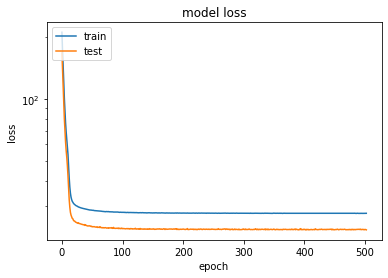

## MODEL SAVED ##


In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', min_delta = 0.001, factor=0.3, patience=200, verbose=0, mode='auto'
)
train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019

input_cvae_erros = [df_errors_final.values]
output_cvae_erros = df_errors_final.values

cvae_error.train(input_cvae_erros, output_cvae_erros, epochs= 2000, verbose=1,
              batch_size=batch_size, callbacks=[earl_stop])

In [48]:
x_encoded_error = cvae_error.encoder.predict(input_cvae_erros)[0]

In [49]:
model_eval_errors,_ = evaluate_latent_code(x_encoded_error, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)

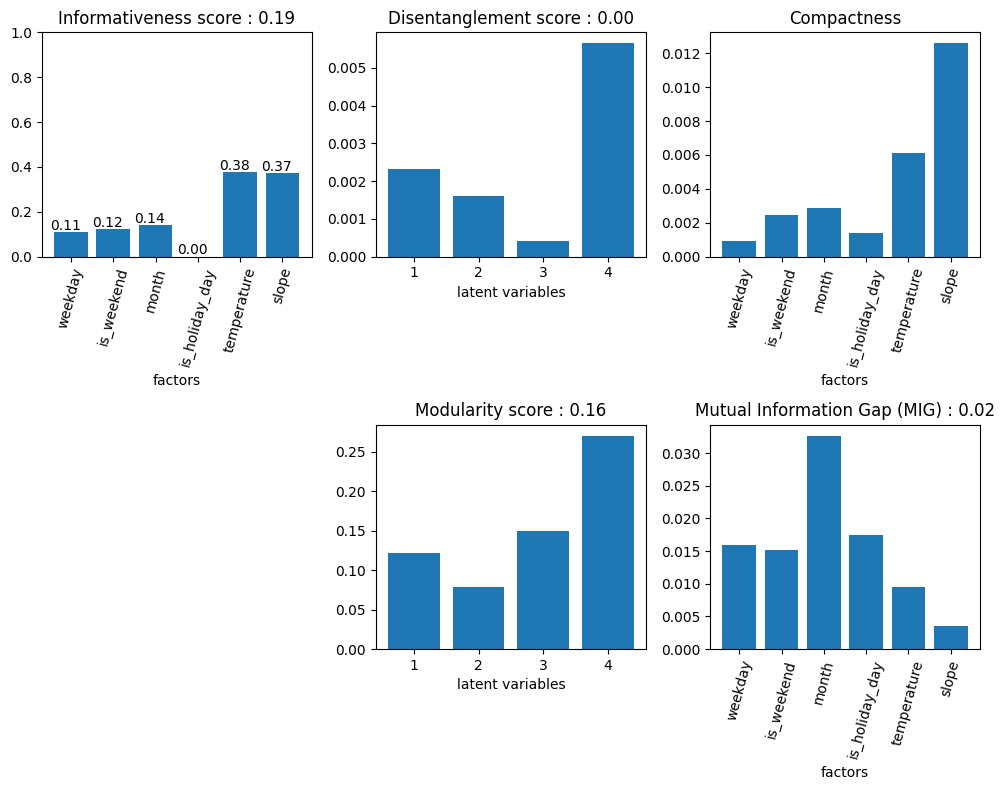

In [50]:
display_evaluation_latent_code(model_eval_errors, z_dim, factorDesc)

In [51]:
def prez_2D_holidays(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c=temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200, cmap='viridis')

    plt.colorbar().set_label('temperature');
    index = factorMatrix[:,-3]==1
    plt.scatter(x=proj[index,0], y=proj[index,1], color='yellow', marker='*',s=450)

    return index, proj

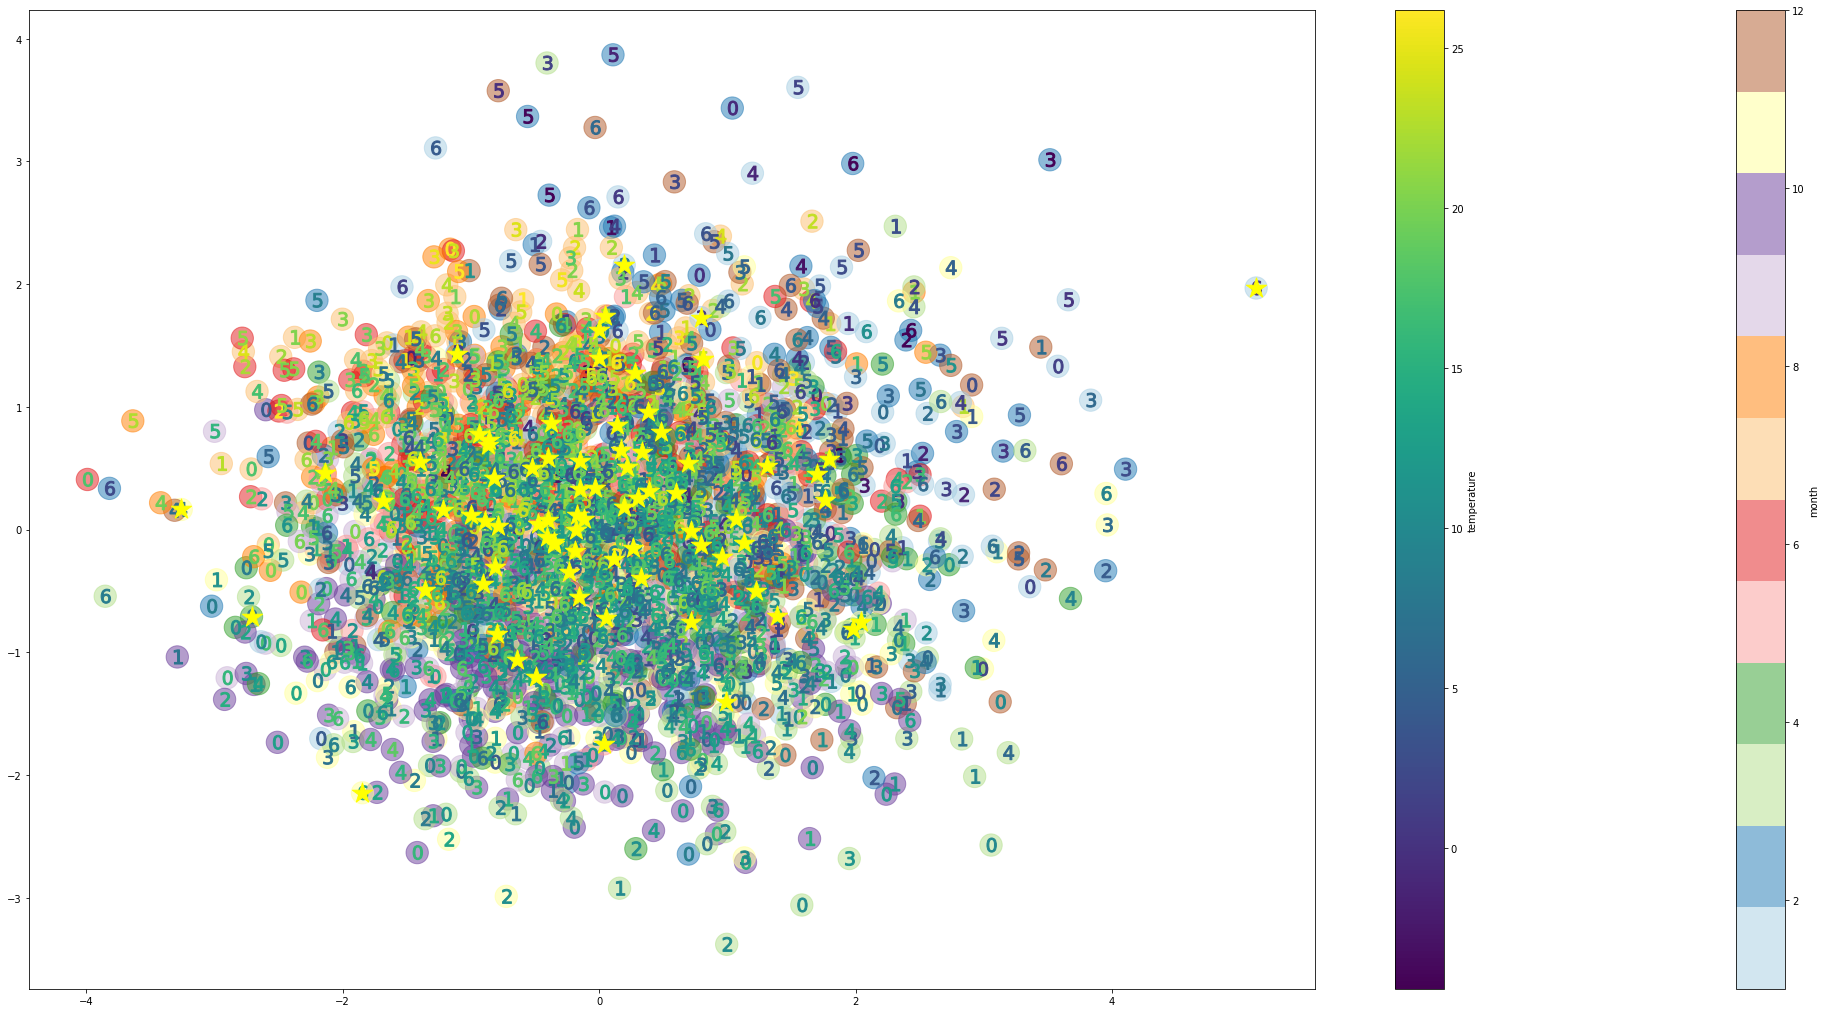

In [52]:
index_outliers, proj = prez_2D_holidays(x_encoded_error, factorMatrix[train_set,:], temperatureMean[train_set])

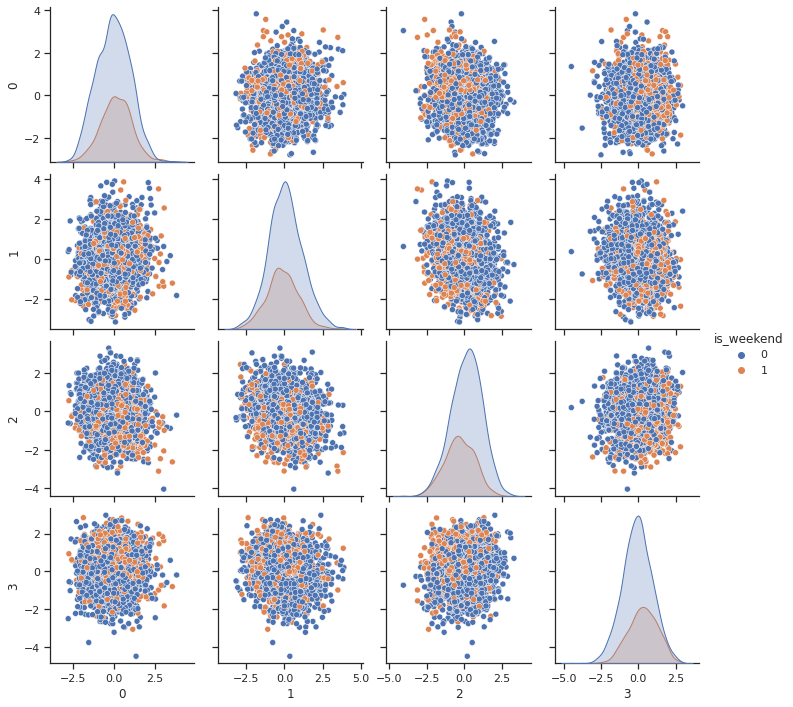

In [53]:
data = {i: x_encoded_error[:,i] for i in range(x_encoded_error.shape[1])}
data['is_weekend'] = df_calendar.is_weekend[train_set]
z=pd.DataFrame(data=data)

import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(z, hue='is_weekend')

In [54]:
pca = PCA(n_components = 4)
pca.fit(input_cvae_erros[0])
x_encoded_pca = pca.transform(input_cvae_erros[0])

In [55]:
model_eval_pca,_ = evaluate_latent_code(x_encoded_pca, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)

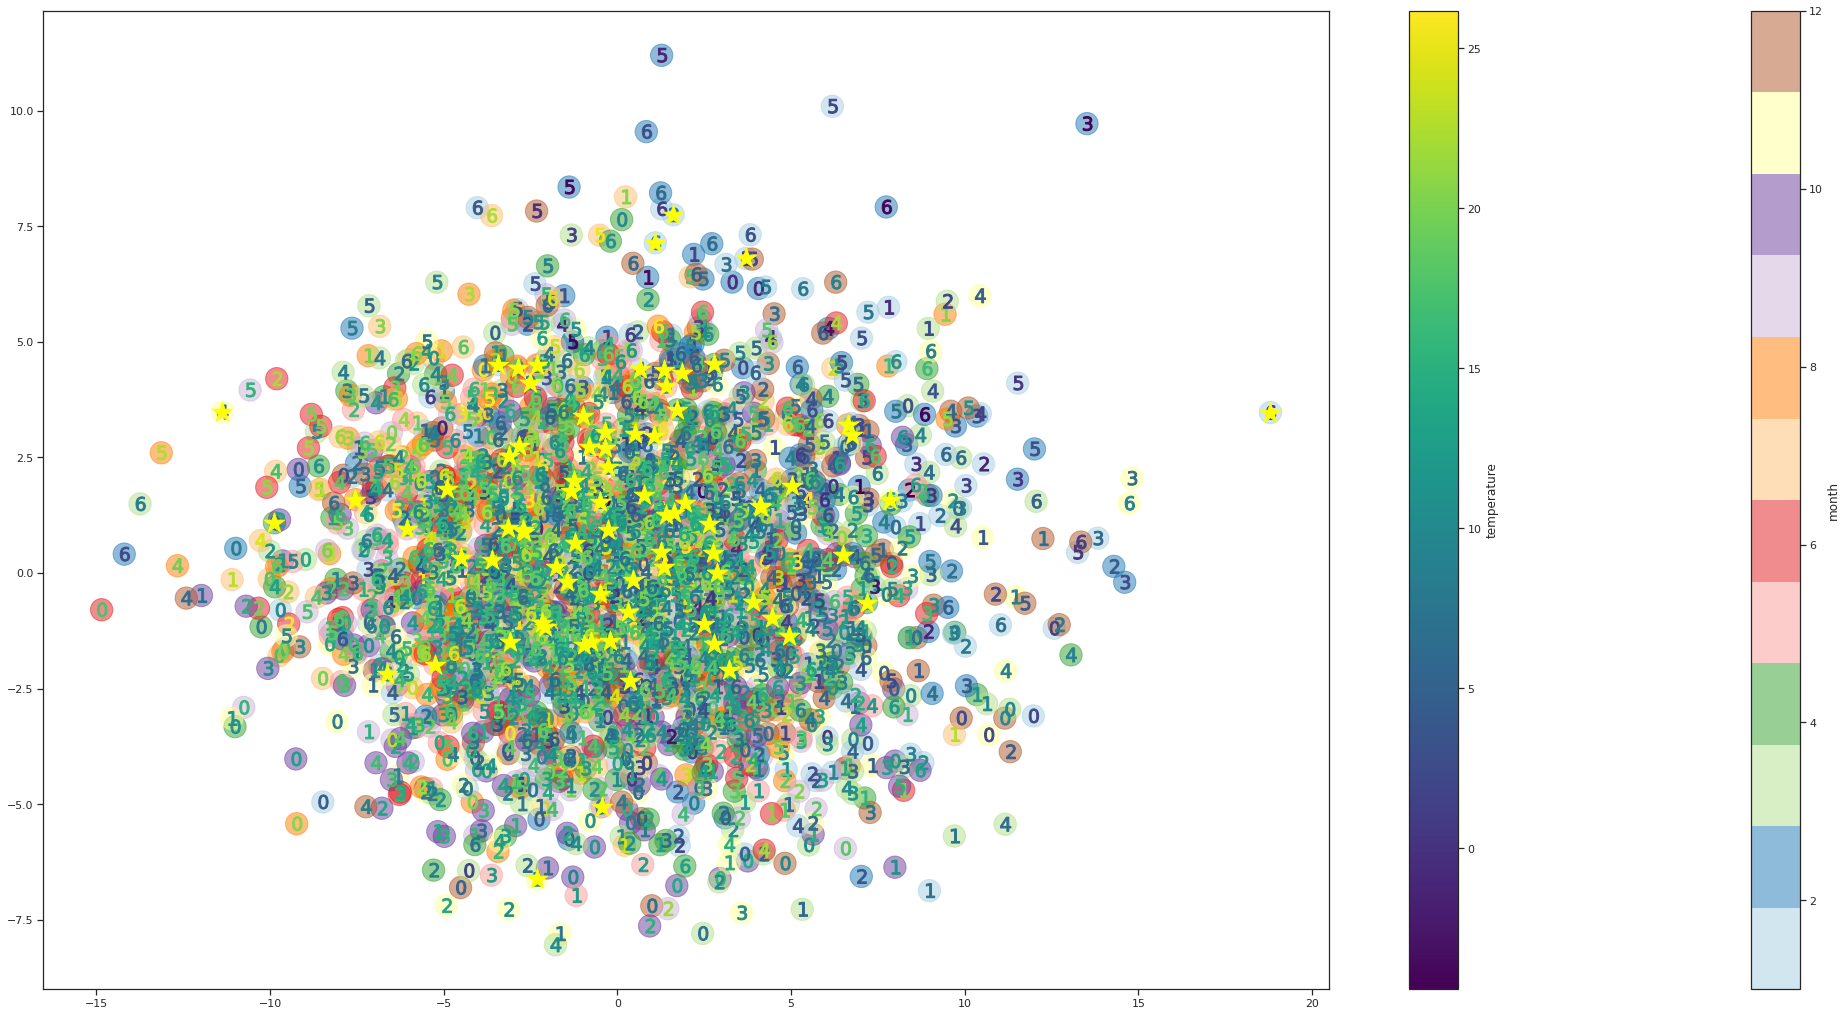

In [56]:
index_outliers, proj = prez_2D_holidays(x_encoded_pca, factorMatrix[train_set,:], temperatureMean[train_set])

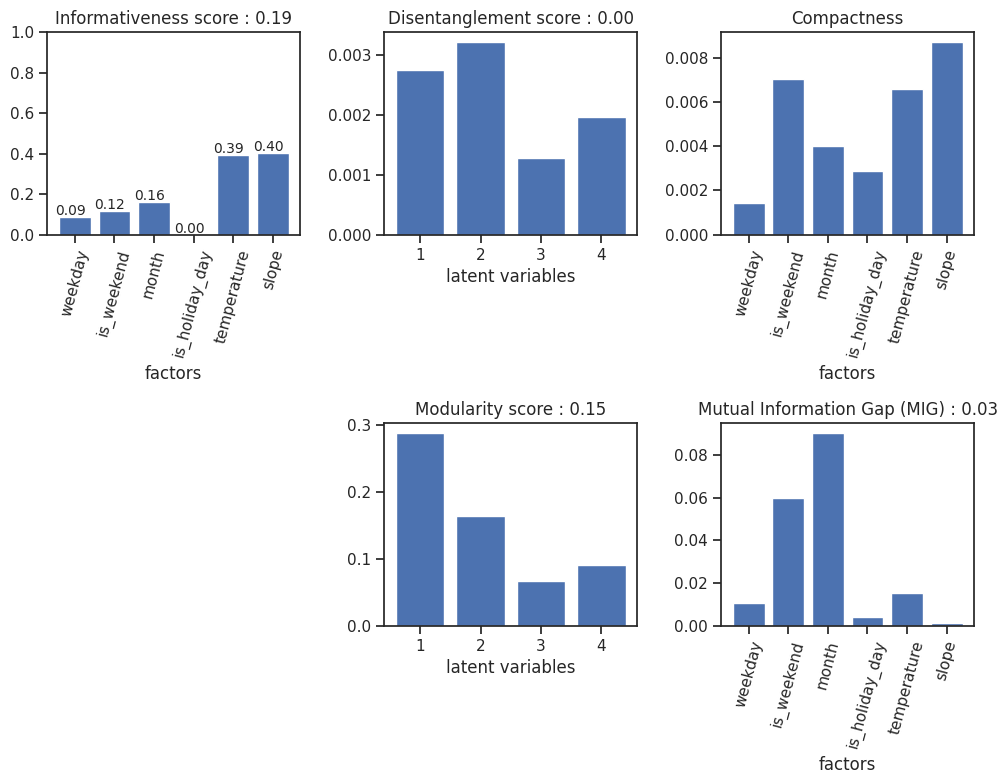

In [57]:
display_evaluation_latent_code(model_eval_pca, z_dim, factorDesc)

Les facteurs explicatifs ne sont plus les mêmes que dans le cas de l'explication de la consommation nationale. Cette recherche étant très chronophage, elle a été mise de côté afin de me concentrer sur d'autres problématiques.